In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

basepath = os.path.expanduser('../')

## Load Dataset

In [3]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_train.pkl'))
# app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_test.pkl'))

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau.pkl'))
# bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau_balance.pkl'))
prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/previous_application.pkl'))
installments = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/installments_payments.pkl')) 
pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/POS_CASH_balance.pkl'))
# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/credit_card_balance.pkl'))

CPU times: user 217 ms, sys: 742 ms, total: 959 ms
Wall time: 2.71 s


## Pipeline

- Create a random sample ( OPTIONAL ).
- Split into train and validation fold.
- Convert categories into numerical data type.
- Feature Engineering.
- CV on train fold.
- Test score on validaiton fold.

In [4]:
def proc_categorical(data, ohe_cols, max_n_cat):
    if ohe_cols is not None:
        for col in ohe_cols:
            feat_ohe = pd.get_dummies(data[col], prefix=f'{col}_', dummy_na=True)
            data.drop(col, axis=1, inplace=True)
            data = pd.concat((data, feat_ohe), axis=1)
            
    for col in data.select_dtypes(include=['category']):
        data[col] = data[col].cat.codes
        
    return data

def proc_numerical(data):
    for col in data.select_dtypes(exclude=['category']):
        data[col+'_na'] = data[col].isnull().astype(np.uint8)
        data[col]       = data[col].fillna(data[col].median())
    
    return data
    
def proc_df(data, target, ohe_cols=None, max_n_cat=None, fill_missing=False):
    y = data.loc[:, target]
    data.drop(target, axis=1, inplace=True)
    
    if fill_missing:
        data = proc_numerical(data)    
    data = proc_categorical(data, ohe_cols, max_n_cat)
    
    return data, y

In [5]:
def current_application_fe(data):
    # feature interacton between external scores
    data.loc[:, 'mean_external_scores'] = (data.EXT_SOURCE_1 + data.EXT_SOURCE_2 + data.EXT_SOURCE_3) / 3
    data.loc[:, 'ext_2_3_mean']         = (data.EXT_SOURCE_2 + data.EXT_SOURCE_3) / 2
    data.loc[:, 'ext_2_3_sum']          = (data.EXT_SOURCE_2 + data.EXT_SOURCE_3)
    data.loc[:, 'ext_2_3_diff']         = (data.EXT_SOURCE_2 - data.EXT_SOURCE_3)
    data.loc[:, 'ext_2_3_div']          = (data.EXT_SOURCE_2 / data.EXT_SOURCE_3)
    
    data.loc[:, 'credit_duration']      = (data.AMT_CREDIT / data.AMT_ANNUITY)
    data.loc[:, 'credit_income']        = (data.AMT_CREDIT - data.AMT_INCOME_TOTAL)
    data.loc[:, 'age_employed']         = (-data.DAYS_BIRTH / 365) + (-data.DAYS_EMPLOYED.replace({365243: np.nan}) / 365)
    data.loc[:, 'ratio_age_employed']   = ((data.DAYS_EMPLOYED.replace({365243: np.nan})) / (data.DAYS_BIRTH))
    
    data.loc[:, 'ratio_goods_income']   = (data.AMT_GOODS_PRICE / data.AMT_INCOME_TOTAL)
    data.loc[:, 'diff_credit_annuity']  = data.AMT_CREDIT - data.AMT_ANNUITY
    data.loc[:, 'ratio_credit_age']     = (data.AMT_CREDIT / (-data.DAYS_BIRTH / 365))
    
    data.loc[:, 'ratio_id_change_age'] = (data.DAYS_ID_PUBLISH / data.DAYS_BIRTH)
    data.loc[:, 'diff_id_change_age']  = (data.DAYS_ID_PUBLISH - data.DAYS_BIRTH)
    data.loc[:, 'ratio_reg_age']       = (data.DAYS_REGISTRATION / data.DAYS_BIRTH)
    data.loc[:, 'diff_reg_age']        = (data.DAYS_REGISTRATION - data.DAYS_BIRTH)
    
    # features that decrease cv scores
    data.loc[:, 'duration_ext_2']       = data.credit_duration + data.EXT_SOURCE_2
    data.loc[:, 'ext_1_2_mean']         = (data.EXT_SOURCE_1 + data.EXT_SOURCE_2) / 2
    data.loc[:, 'ext_1_3_mean']         = (data.EXT_SOURCE_1 + data.EXT_SOURCE_3) / 2 
    
    data.loc[:, 'ratio_goods_annuity']  = data.loc[:, 'AMT_GOODS_PRICE'] / data.loc[:, 'AMT_ANNUITY']
    data.loc[:, 'ratio_annuity_income'] = data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'AMT_INCOME_TOTAL']
    data.loc[:, 'duration_ext_3']       = data.credit_duration + data.EXT_SOURCE_3
    
    data.loc[:, 'diff_credit_goods']     = data.AMT_CREDIT - data.AMT_GOODS_PRICE
    data.loc[:, 'ratio_annuity_score_3'] = (data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'EXT_SOURCE_3']).replace([np.inf, -np.inf], np.nan)
    data.loc[:, 'ratio_annuity_score_2'] = (data.loc[:, 'AMT_ANNUITY'] / data.loc[:, 'EXT_SOURCE_2']).replace([np.inf, -np.inf], np.nan)
    
    data.loc[:, 'ratio_annuity_income']  = data.AMT_ANNUITY / data.AMT_INCOME_TOTAL
    
    return data

def installments_fe(prev_app, installments, data):
    res = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'SK_ID_PREV']]\
              .merge(installments,
                     how='left'
                    )
    tmp = res.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
    data.loc[:, 'AMT_PAYMENT_SUM'] = data.SK_ID_CURR.map(tmp).map(np.log1p)
    
    tmp = res.groupby('SK_ID_CURR')['AMT_PAYMENT'].mean()
    data.loc[:, 'AMT_PAYMENT_MEAN'] = data.SK_ID_CURR.map(tmp).map(np.log1p)
    
    tmp = res.groupby('SK_ID_CURR')['AMT_PAYMENT'].median()
    data.loc[:, 'AMT_PAYMENT_MEDIAN'] = data.SK_ID_CURR.map(tmp).map(np.log1p)
    
    data.loc[:, 'ratio_sum_payments_income'] = data.AMT_PAYMENT_SUM / data.AMT_INCOME_TOTAL
    
    diff_actual_decided = (installments.DAYS_INSTALMENT - installments.DAYS_ENTRY_PAYMENT)
    tmp = diff_actual_decided.groupby(installments.SK_ID_CURR).median()
    
    data.loc[:, 'median_diff_actual_decided'] = data.SK_ID_CURR.map(tmp)
    
    tmp = diff_actual_decided.groupby(installments.SK_ID_CURR).sum()
    data.loc[:, 'delay_in_installment_payments'] = data.SK_ID_CURR.map(tmp)
    
    diff_actual_decided = -(installments.DAYS_ENTRY_PAYMENT - installments.DAYS_INSTALMENT)
    diff_actual_decided = diff_actual_decided.groupby(installments.SK_ID_CURR).min()
    
    data.loc[:, 'min_diff_actual_decided'] = data.SK_ID_CURR.map(diff_actual_decided)
    
    tmp = installments.AMT_INSTALMENT - installments.AMT_PAYMENT
    tmp = tmp.groupby(installments.SK_ID_CURR).median()
    data.loc[:, 'diff_installment_amount'] = data.SK_ID_CURR.map(tmp)
    
    del res, tmp
    gc.collect();
    
    return data

def bureau_fe(bureau, data):
    mask = (bureau.CREDIT_ACTIVE == 'Active')
    res         = bureau.loc[mask &\
                         (bureau.AMT_CREDIT_SUM_DEBT > 0), 
                         ['SK_ID_CURR', 'CREDIT_ACTIVE', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']
                        ]

    total_sum     = res.groupby(res.SK_ID_CURR)['AMT_CREDIT_SUM'].sum().astype(np.float32)
    total_debt    = res.groupby(res.SK_ID_CURR)['AMT_CREDIT_SUM_DEBT'].sum().astype(np.float32)
    debt_by_sum   = total_debt.div(total_sum, fill_value=np.nan).astype(np.float32)
    debt_from_sum = total_debt.subtract(total_sum, fill_value=0).astype(np.float32)

    data.loc[:, 'ratio_debt_credit_sum'] = data.SK_ID_CURR.map(debt_by_sum)
    data.loc[:, 'diff_debt_credit_sum']  = data.SK_ID_CURR.map(debt_from_sum)
    
    
    latest_credit = bureau.loc[mask].groupby('SK_ID_CURR')['DAYS_CREDIT'].max()
    data.loc[:, 'latest_credit'] = data.SK_ID_CURR.map(latest_credit)
    
    res = bureau[mask].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].min()
    data.loc[:, 'AMT_CREDIT_SUM_min'] = data.SK_ID_CURR.map(res).map(np.log1p)
    
    res = bureau[mask].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].max()
    data.loc[:, 'AMT_CREDIT_SUM_max'] = data.SK_ID_CURR.map(res).map(np.log1p)
    
    data.loc[:, 'ratio_max_min_amt_credit_sum'] = data.AMT_CREDIT_SUM_max.div(data.AMT_CREDIT_SUM_min, fill_value=np.nan)
    
    res = (bureau[mask].DAYS_ENDDATE_FACT - bureau[mask].DAYS_CREDIT) / 365
    res = res.groupby(bureau[mask].SK_ID_CURR).median()
    data.loc[:, 'closed_credit_duration'] = data.SK_ID_CURR.map(res)
    
    mask = bureau.CREDIT_ACTIVE == 'Active'
    res  = (bureau[mask].DAYS_CREDIT_ENDDATE - bureau[mask].DAYS_CREDIT) / 365
    res  = res.groupby(bureau[mask].SK_ID_CURR).median()
    data.loc[:, 'active_closed_duration'] = data.SK_ID_CURR.map(res)
    
    data.loc[:, 'diff_closed_active_duration']  = data.closed_credit_duration.subtract(data.active_closed_duration, fill_value=0)   
    data.loc[:, 'ratio_closed_active_duration'] = data.closed_credit_duration.div(data.active_closed_duration, fill_value=np.nan)
    
    res = (-bureau.loc[bureau.DAYS_ENDDATE_FACT.isnull(), :].groupby('SK_ID_CURR')['DAYS_CREDIT'].min() / 365)
    res = data.SK_ID_CURR.map(res)

    data.loc[:, 'oldest_loan_age'] = (-data.DAYS_BIRTH / 365).subtract(res, fill_value=0)
    
    res = (-bureau.loc[bureau.DAYS_ENDDATE_FACT.isnull(), :].groupby('SK_ID_CURR')['DAYS_CREDIT'].max() / 365)
    res = data.SK_ID_CURR.map(res)

    data.loc[:, 'max_loan_age'] = (-data.DAYS_BIRTH / 365).subtract(res, fill_value=0)
    
    res = (-bureau.loc[bureau.DAYS_ENDDATE_FACT.isnull(), :].groupby('SK_ID_CURR')['DAYS_CREDIT'].median() / 365)
    res = data.SK_ID_CURR.map(res)

    data.loc[:, 'median_loan_age'] = (-data.DAYS_BIRTH / 365).subtract(res, fill_value=0)
    
    res = bureau.loc[bureau.CREDIT_ACTIVE == 'Closed', ['SK_ID_CURR', 'DAYS_ENDDATE_FACT']]
    res = res.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].median() # most recently ended credit for a client

    tmp = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'DAYS_CREDIT']]
    tmp = tmp.groupby('SK_ID_CURR')['DAYS_CREDIT'].median() # most recently applied credit at Home credit

    res   = tmp.div(res, fill_value=0)
    data.loc[:, 'median_ratio_end_curr_credit'] = data.SK_ID_CURR.map(res)

    del res, tmp
    gc.collect()
    
    return data

def previous_application_fe(prev_app, data):
    mask = prev_app.NAME_CONTRACT_STATUS == 'Approved'

    # difference of down_payment * rate and annuity
    diff_dp_annuity = ((prev_app[mask].AMT_DOWN_PAYMENT * prev_app[mask].RATE_DOWN_PAYMENT) - prev_app[mask].AMT_ANNUITY).replace([np.inf, -np.inf])
    diff_dp_annuity = diff_dp_annuity.groupby(prev_app[mask].SK_ID_CURR).sum()
    data.loc[:, 'diff_dp_annuity'] = data.SK_ID_CURR.map(diff_dp_annuity).astype(np.float32)
    
    
    res  = prev_app.loc[mask, ['SK_ID_CURR',
                        'AMT_ANNUITY',
                        'AMT_CREDIT',
                        'CNT_PAYMENT']]

    tmp  = res.AMT_CREDIT / (res.AMT_ANNUITY * res.CNT_PAYMENT) 
    tmp  = tmp.groupby(res.SK_ID_CURR).mean()
    data.loc[:, 'prev_app_rate']  = data.SK_ID_CURR.map(tmp)
    
    max_credit_term = prev_app[mask].groupby('SK_ID_CURR')['CNT_PAYMENT'].max()
    data.loc[:, 'max_credit_term'] = data.SK_ID_CURR.map(max_credit_term)
    
    min_credit_term = prev_app[mask].groupby('SK_ID_CURR')['CNT_PAYMENT'].max()
    data.loc[:, 'min_credit_term'] = data.SK_ID_CURR.map(min_credit_term)
    
    data.loc[:, 'diff_max_min_credit_term'] = data.max_credit_term.subtract(data.min_credit_term, fill_value=0)
    
    
    res                        = prev_app[prev_app.NAME_CONTRACT_STATUS == 'Approved'].groupby('SK_ID_CURR')['DAYS_DECISION'].min()
    data.loc[:, 'most_oldest_prev_application'] = data.SK_ID_CURR.map(res)
    
    res                        = prev_app[prev_app.NAME_CONTRACT_STATUS == 'Approved'].groupby('SK_ID_CURR')['DAYS_DECISION'].median()
    data.loc[:, 'median_prev_application']  = data.SK_ID_CURR.map(res)
    
    del res, tmp
    gc.collect()
    
    return data

def pos_cash_fe(prev_app, pos_cash, data):
    res = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR',
                                                           'SK_ID_PREV',
                                                           'AMT_CREDIT',
                                                           'AMT_ANNUITY',
                                                           'RATE_DOWN_PAYMENT'
                                                          ]].merge(pos_cash.loc[:, ['SK_ID_CURR',
                                                                                    'SK_ID_PREV',
                                                                                    'CNT_INSTALMENT',
                                                                                    'CNT_INSTALMENT_FUTURE'
                                                                                   ]],
                                                                   how='left'
                                                                  )
    
    res.loc[:, 'credit_share_left']  = (res.AMT_ANNUITY * res.CNT_INSTALMENT_FUTURE * res.RATE_DOWN_PAYMENT) / res.AMT_CREDIT
    tmp        = res.groupby('SK_ID_CURR')['credit_share_left'].mean()
    data.loc[:, 'credit_share_left'] = data.SK_ID_CURR.map(tmp)
    
    tmp = res.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].max()
    data.loc[:, 'max_cnt_instalment_future'] = data.SK_ID_CURR.map(tmp)
    
    tmp = res.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].min()
    data.loc[:, 'min_cnt_instalment_future'] = data.SK_ID_CURR.map(tmp)
    
    t   = res.loc[:, 'CNT_INSTALMENT'] - res.loc[:, 'CNT_INSTALMENT_FUTURE']
    tmp = t.groupby(res.SK_ID_CURR).sum()
    data.loc[:, 'current_installment_status'] = data.SK_ID_CURR.map(tmp)
    
    ratio_paid_unpaid = pos_cash.CNT_INSTALMENT_FUTURE.div(pos_cash.CNT_INSTALMENT, fill_value=np.nan)
    ratio_paid_unpaid = ratio_paid_unpaid.groupby(pos_cash.SK_ID_CURR).mean()
    data.loc[:, 'ratio_paid_unpaid'] = data.SK_ID_CURR.map(ratio_paid_unpaid)

    del res, t, tmp, ratio_paid_unpaid
    gc.collect()
    
    return data

def bureau_prev_fe(prev_app, bureau, data):
    res = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR',
                                                           'DAYS_TERMINATION'
                                                          ]]\
        .merge(bureau.loc[bureau.CREDIT_ACTIVE == 'Closed', ['SK_ID_CURR', 'DAYS_CREDIT']])
    res.loc[:, 'DAYS_TERMINATION'] = res.DAYS_TERMINATION.replace({365243: np.nan})
    
    res.loc[:, 'prev_app_end_bureau_start'] = res.DAYS_CREDIT - res.DAYS_TERMINATION
    tmp = res.groupby('SK_ID_CURR')['prev_app_end_bureau_start'].min()

    data.loc[:, 'prev_app_end_bureau_start_min'] = data.SK_ID_CURR.map(tmp)
    
    tmp = res.groupby('SK_ID_CURR')['prev_app_end_bureau_start'].max()
    data.loc[:, 'prev_app_end_bureau_start_max'] = data.SK_ID_CURR.map(tmp)
    
    del res, tmp
    gc.collect()
    
    return data
    
def feature_interactions(data):
    data.loc[:, 'mult_amt_payment_sum_delay_installment'] = data.AMT_PAYMENT_SUM * data.delay_in_installment_payments
    
    return data

In [6]:
# create a random sample
np.random.seed(SEED)

N_SAMPLES        = int(.5 * len(app_train))
app_train_sample = app_train.sample(n=N_SAMPLES)

In [7]:
# process datafraome
ohe_cols = ['NAME_EDUCATION_TYPE']
%time df_proc, y = proc_df(app_train_sample, 'TARGET', ohe_cols=ohe_cols, fill_missing=False)

CPU times: user 126 ms, sys: 20.6 ms, total: 146 ms
Wall time: 144 ms


In [8]:
%%time

# feature engineering
df_proc = current_application_fe(df_proc)
df_proc = installments_fe(prev_app, installments, df_proc)
df_proc = bureau_fe(bureau, df_proc)
df_proc = previous_application_fe(prev_app, df_proc)
df_proc = pos_cash_fe(prev_app, pos_cash, df_proc)
df_proc = feature_interactions(df_proc)
df_proc = bureau_prev_fe(prev_app, bureau, df_proc)

CPU times: user 25 s, sys: 4.55 s, total: 29.5 s
Wall time: 31.1 s


In [9]:
# split into training and validation data
X_tr, X_val, y_tr, y_val = train_test_split(df_proc, 
                                            y, 
                                            stratify=y, 
                                            test_size=.2, 
                                            random_state=SEED)

In [18]:
%%time

RANDOM_NOISE = 100

# Cross-validation
clf = lgb.LGBMClassifier(num_leaves=10, 
                         learning_rate=.05, 
                         n_estimators=800, 
                         colsample_bytree=.1, 
                         random_state=SEED + RANDOM_NOISE, 
                         n_jobs=-1)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED + RANDOM_NOISE)
kf  = KFold(n_splits=3, shuffle=True, random_state=SEED + RANDOM_NOISE)

scores = cross_val_score(clf, X_tr, y_tr, scoring='roc_auc', cv=kf)
print('Mean Scores: {}, Std Scores: {}'.format(np.mean(scores), np.std(scores)))

Mean Scores: 0.7767423080998856, Std Scores: 0.0008690327860173181
CPU times: user 3min 59s, sys: 919 ms, total: 4min
Wall time: 1min 4s


`Mean Scores: 0.7767423080998856, Std Scores: 0.0008690327860173181`

In [19]:
%%time

# Performance on holdout 
clf.fit(X_tr, y_tr)
y_hat = clf.predict_proba(X_val)[:, 1]
print('AUC: {}'.format(roc_auc_score(y_val, y_hat)))

AUC: 0.772216517344118
CPU times: user 1min 58s, sys: 379 ms, total: 1min 59s
Wall time: 32 s


`AUC: 0.772216517344118`

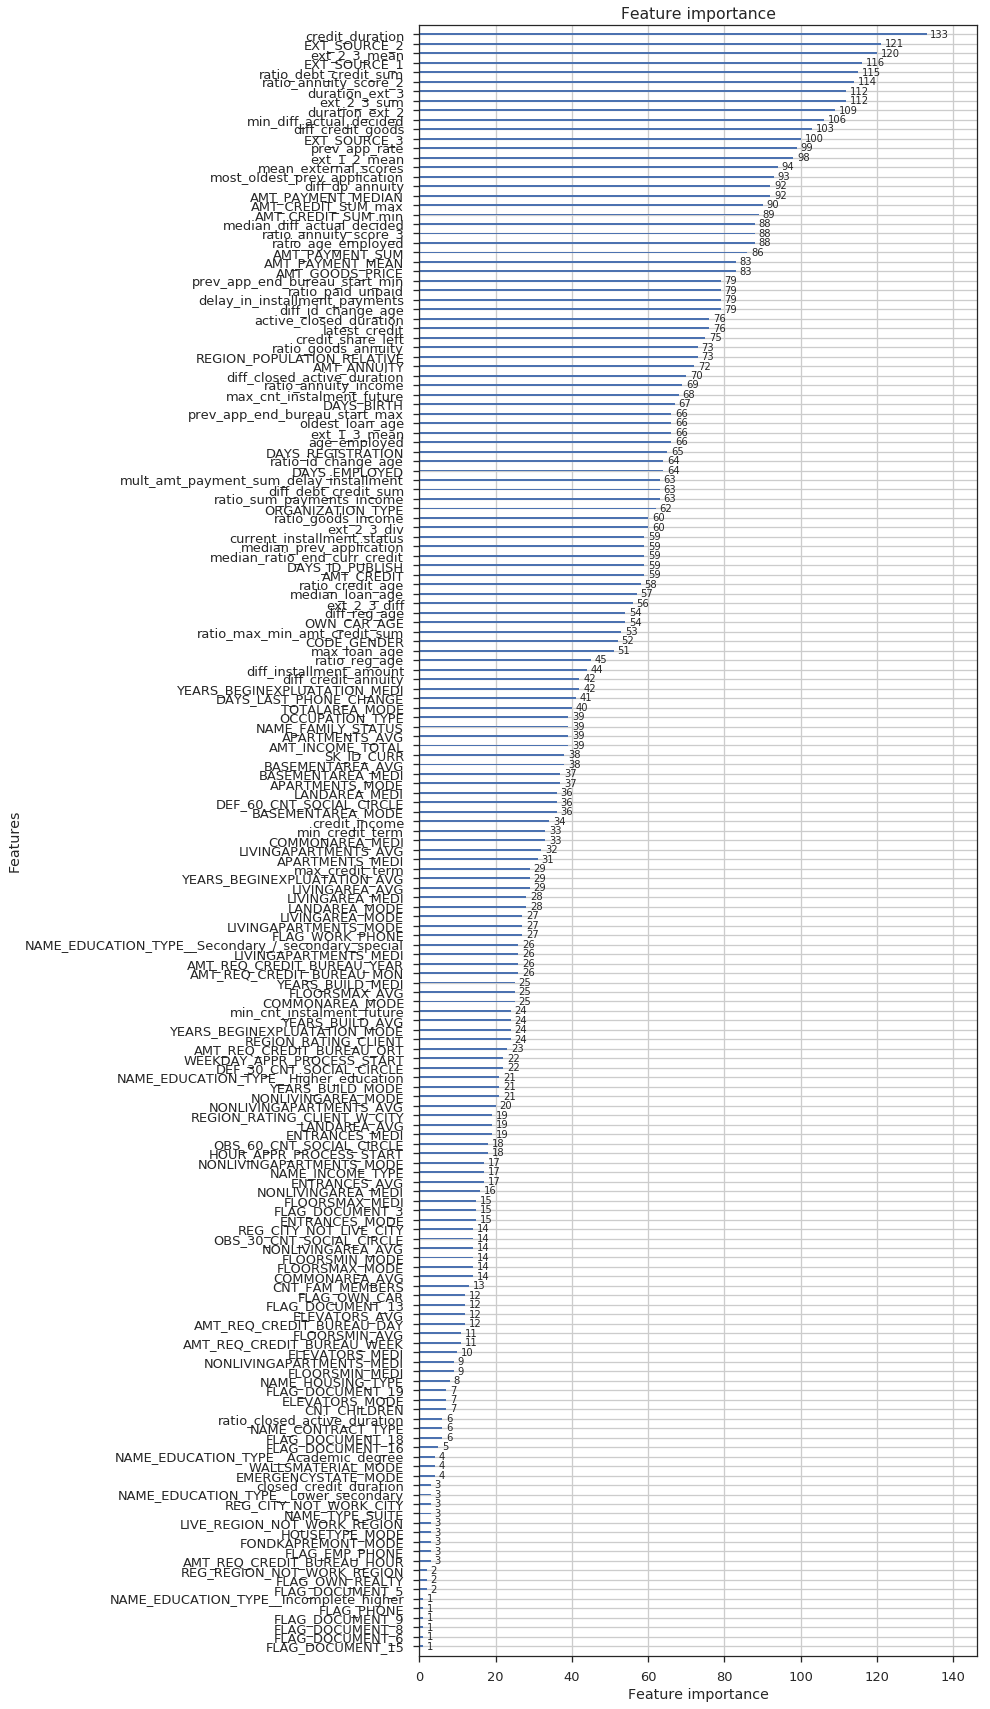

In [21]:
# feature importance
fig, ax = plt.subplots(1, figsize=(10, 30))
lgb.plot_importance(clf, ax=ax);